In [1]:
!pip install medmnist
!pip install -U libauc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_c

Base model using the ResNet18 CNN. This is our control model, on which we can tune hyperperameters later on.

---


Also note that we can use different datasets within the MNIST library by changing the dataflag.

---


Refer: https://medmnist.com/

In [16]:
import torch
import numpy as np
import torchvision
from torchvision import transforms
from libauc.models import resnet18 as ResNet18
from libauc.losses import AUCMLoss
from torch.nn import BCELoss
import torch.nn as nn
from torch.optim import SGD
from libauc.optimizers import PESG
import medmnist
from medmnist import INFO, Evaluator
import os
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from libauc.metrics import auc_roc_score

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(2024)
np.random.seed(2024)

# Check GPU availability
torch.cuda.is_available()

# Check GPU device name
import tensorflow as tf
tf.test.gpu_device_name()

# Additional imports
import torch.utils.data as data


**Hyperparameters**

In [10]:
# HyperParameters
SEED = 123
BATCH_SIZE = 128
imratio = 0.1 # for demo
total_epochs = 100
decay_epochs = [50, 75]

lr = 0.1
margin = 1.0
epoch_decay = 0.003 # refers gamma in the paper
weight_decay = 0.0001

# oversampling minority class, you can tune it in (0, 0.5]
# e.g., sampling_rate=0.2 is that num of positive samples in mini-batch is sampling_rate*batch_size=13
sampling_rate = 0.2

In [11]:
#data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [12]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 559580/559580 [00:00<00:00, 708653.59it/s] 

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [13]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: 

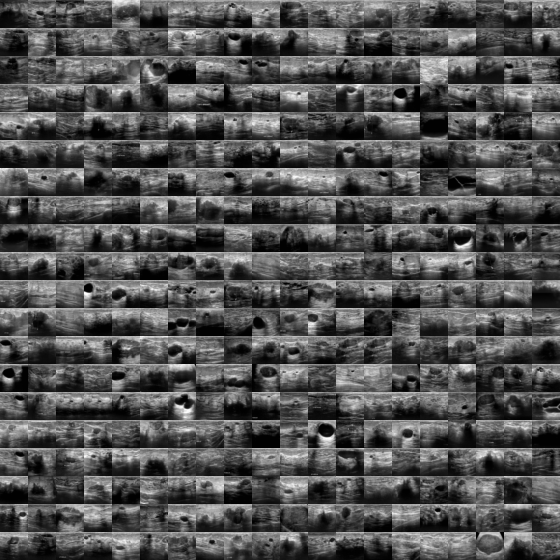

In [14]:
train_dataset.montage(length=20)

In [17]:
######### DEFAULT ##############

# You can include sigmoid/l2 activations on model's outputs before computing loss
model = ResNet18(pretrained=True, last_activation=None, num_classes=1)
model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3,bias=False)
model = model.cuda()

# You can also pass Loss.a, Loss.b, Loss.alpha to optimizer (for old version users)
loss_fn = AUCMLoss()
optimizer = PESG(model.parameters(),
                 loss_fn=loss_fn,
                 lr=lr,
                 momentum=0.9,
                 margin=margin,
                 epoch_decay=epoch_decay,
                 weight_decay=weight_decay)

In [18]:
print ('Start Training')
print ('-'*30)

train_log = []
test_log = []
for epoch in range(total_epochs):
     if epoch in decay_epochs:
         optimizer.update_regularizer(decay_factor=10) # decrease learning rate by 10x & update regularizer

     train_loss = []
     model.train()
     for data, targets in train_loader:
         data, targets  = data.cuda(), targets.cuda()
         y_pred = model(data)
         y_pred = torch.sigmoid(y_pred)
         loss = loss_fn(y_pred, targets)
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
         train_loss.append(loss.item())

     # evaluation on train & test sets
     model.eval()
     train_pred_list = []
     train_true_list = []
     for train_data, train_targets in train_loader_at_eval:
         train_data = train_data.cuda()
         train_pred = model(train_data)
         train_pred_list.append(train_pred.cpu().detach().numpy())
         train_true_list.append(train_targets.numpy())
     train_true = np.concatenate(train_true_list)
     train_pred = np.concatenate(train_pred_list)
     train_auc = auc_roc_score(train_true, train_pred)
     train_loss = np.mean(train_loss)

     test_pred_list = []
     test_true_list = []
     for test_data, test_targets in test_loader:
         test_data = test_data.cuda()
         test_pred = model(test_data)
         test_pred_list.append(test_pred.cpu().detach().numpy())
         test_true_list.append(test_targets.numpy())
     test_true = np.concatenate(test_true_list)
     test_pred = np.concatenate(test_pred_list)
     val_auc =  auc_roc_score(test_true, test_pred)
     model.train()

     # print results
     print("epoch: %s, train_loss: %.4f, train_auc: %.4f, test_auc: %.4f, lr: %.4f"%(epoch, train_loss, train_auc, val_auc, optimizer.lr ))
     train_log.append(train_auc)
     test_log.append(val_auc)

Start Training
------------------------------
epoch: 0, train_loss: 0.1114, train_auc: 0.4771, test_auc: 0.4687, lr: 0.1000
epoch: 1, train_loss: 0.1676, train_auc: 0.4766, test_auc: 0.4344, lr: 0.1000
epoch: 2, train_loss: 0.1335, train_auc: 0.4883, test_auc: 0.4259, lr: 0.1000
epoch: 3, train_loss: 0.1160, train_auc: 0.6900, test_auc: 0.6761, lr: 0.1000
epoch: 4, train_loss: 0.0651, train_auc: 0.6178, test_auc: 0.6147, lr: 0.1000
epoch: 5, train_loss: 0.0574, train_auc: 0.6985, test_auc: 0.6713, lr: 0.1000
epoch: 6, train_loss: 0.0422, train_auc: 0.7506, test_auc: 0.7400, lr: 0.1000
epoch: 7, train_loss: 0.0007, train_auc: 0.8118, test_auc: 0.7308, lr: 0.1000
epoch: 8, train_loss: -0.0135, train_auc: 0.9192, test_auc: 0.7694, lr: 0.1000
epoch: 9, train_loss: -0.0136, train_auc: 0.9687, test_auc: 0.8164, lr: 0.1000
epoch: 10, train_loss: -0.0105, train_auc: 0.9879, test_auc: 0.8578, lr: 0.1000
epoch: 11, train_loss: -0.0070, train_auc: 0.9937, test_auc: 0.8630, lr: 0.1000
epoch: 12, t

In [19]:
torch.save(model, "resnet_breast.pt")

Text(0.5, 0, 'Epoch')

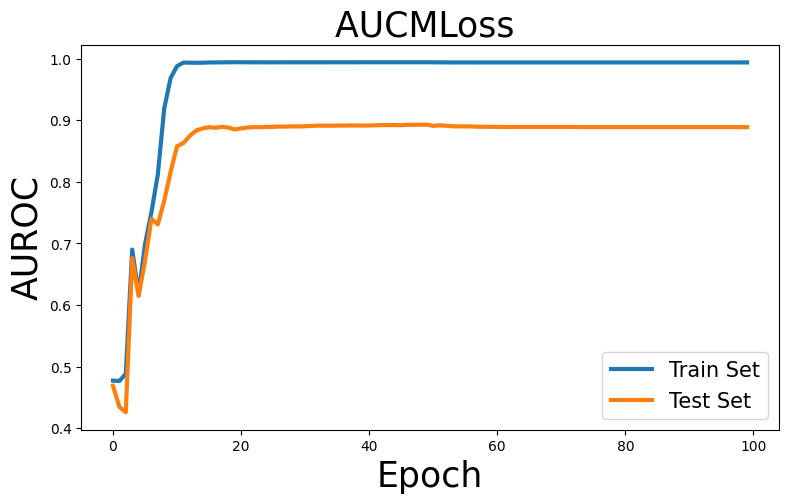

In [20]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,5)
x=np.arange(len(train_log))
plt.figure()
plt.plot(x, train_log, linestyle='-', label='Train Set', linewidth=3)
plt.plot(x, test_log,  linestyle='-', label='Test Set', linewidth=3)
plt.title('AUCMLoss ',fontsize=25)
plt.legend(fontsize=15)
plt.ylabel('AUROC', fontsize=25)
plt.xlabel('Epoch', fontsize=25)